In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from pathlib import Path
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import IsolationForest, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

### 1) Perform some EDA

In [2]:
dir = r"C:\Users\tnaga\Documents\MMA\Winter 2023 - 1\INSY695_Enterprise_DS\Goodreads_Book_Recommendation\Modelling"
os.chdir(dir)

In [3]:
df_users = pd.read_csv("../Data/Data_Final/user_details.csv")

In [4]:
df = pd.read_csv("../Data/Data_Final/all_books.csv")

In [5]:
df.shape

(274233, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274233 entries, 0 to 274232
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   url            274233 non-null  object 
 1   book_pages     274233 non-null  object 
 2   num_of_rating  274233 non-null  int64  
 3   num_of_review  274233 non-null  int64  
 4   genre          274233 non-null  object 
 5   publish        274233 non-null  object 
 6   author         274231 non-null  object 
 7   title          274233 non-null  object 
 8   rating         274233 non-null  float64
 9   award          274233 non-null  object 
 10  isbn           274233 non-null  object 
 11  book_id        274233 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 25.1+ MB


In [7]:
df.describe()

,num_of_rating,num_of_review,rating,book_id
count,274233.000000,274233.000000,274233.000000,2.742330e+05
mean,166.446161,148.208669,3.995653,2.943557e+07
std,246.932018,208.624871,0.333503,2.084824e+07
min,0.000000,0.000000,0.000000,1.000000e+00
25%,4.000000,12.000000,3.800000,1.015514e+07
50%,34.000000,57.000000,4.020000,2.875782e+07
75%,236.000000,190.000000,4.220000,4.992890e+07
max,999.000000,999.000000,5.000000,9.720231e+07


In [8]:
df.isnull().sum()

url              0
book_pages       0
num_of_rating    0
num_of_review    0
genre            0
publish          0
author           2
title            0
rating           0
award            0
isbn             0
book_id          0
dtype: int64

In [9]:
# check percentage of nulls
(df.isnull().sum() / df.shape[0]) * 100

url              0.000000
book_pages       0.000000
num_of_rating    0.000000
num_of_review    0.000000
genre            0.000000
publish          0.000000
author           0.000729
title            0.000000
rating           0.000000
award            0.000000
isbn             0.000000
book_id          0.000000
dtype: float64

In [10]:
df['isbn'] = df['isbn'].astype(str)

In [11]:
# Not very much correlation in the dataset
df.corr()

C:\Users\tnaga\AppData\Local\Temp\ipykernel_11036\306365476.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,num_of_rating,num_of_review,rating,book_id
num_of_rating,1.000000,-0.236052,0.019059,0.075025
num_of_review,-0.236052,1.000000,-0.022975,-0.037285
rating,0.019059,-0.022975,1.000000,0.231202
book_id,0.075025,-0.037285,0.231202,1.000000


array([[<AxesSubplot: xlabel='num_of_rating', ylabel='num_of_rating'>,
        <AxesSubplot: xlabel='num_of_review', ylabel='num_of_rating'>,
        <AxesSubplot: xlabel='rating', ylabel='num_of_rating'>,
        <AxesSubplot: xlabel='book_id', ylabel='num_of_rating'>],
       [<AxesSubplot: xlabel='num_of_rating', ylabel='num_of_review'>,
        <AxesSubplot: xlabel='num_of_review', ylabel='num_of_review'>,
        <AxesSubplot: xlabel='rating', ylabel='num_of_review'>,
        <AxesSubplot: xlabel='book_id', ylabel='num_of_review'>],
       [<AxesSubplot: xlabel='num_of_rating', ylabel='rating'>,
        <AxesSubplot: xlabel='num_of_review', ylabel='rating'>,
        <AxesSubplot: xlabel='rating', ylabel='rating'>,
        <AxesSubplot: xlabel='book_id', ylabel='rating'>],
       [<AxesSubplot: xlabel='num_of_rating', ylabel='book_id'>,
        <AxesSubplot: xlabel='num_of_review', ylabel='book_id'>,
        <AxesSubplot: xlabel='rating', ylabel='book_id'>,
        <AxesSubplot: xl

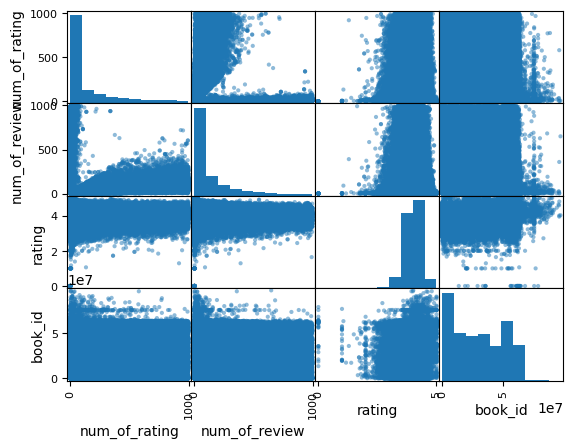

In [12]:
# make num ratings and num reviews on a log scale
scatter_matrix(df)

### 2a) Data Transformation

In [13]:
# remove unique identifiers/unnecessary column
df_store = df[["isbn", "book_id", "genre", "author", "title"]]
df = df.drop(columns=["url", "isbn", "book_id", "title"])
df = df.dropna(how="any")

In [14]:
# split punlish into year month day columns from string
df_date = df['publish'].str.replace("First published ","").str.replace("Published ", "").str.replace("Expected ", "").str.replace("publication ", "").str.split(" ", expand=True)

In [15]:
# Get Dates
df_date.columns = ["Month", "Day", "Year"]
df["year"] = df_date["Year"].astype(int)

df = df.drop(columns="publish")

In [16]:
# Get Genre Counts Frequency Encoded
df_genre_counts = df["genre"].value_counts()
df['genre_freq'] = df['genre'].map(df_genre_counts) / df.shape[0]
df = df.drop(columns="genre")

In [17]:
# Get Author Counts Frequency Encoded
df_author_counts = df["author"].value_counts()
df['author_freq'] = df['author'].map(df_author_counts) / df.shape[0]
df = df.drop(columns="author")

In [18]:
# get number of pages and add a field if the value is missing or not
df_books = df["book_pages"].str.replace(",", "").str.split(" ", expand=True)

non_nums =[]
for item in df_books[0].unique():
    try:
        int(item)
    except:
        non_nums.append(item)

df["pages"] = df_books[0].replace(non_nums, np.nan).astype(float) 
df["page_missing"] = [1 if val is np.nan else 0 for val in df["pages"]]

df = df.drop(columns="book_pages")

(array([3.43000e+02, 2.18700e+03, 1.40610e+04, 8.14560e+04, 1.51894e+05,
        1.84700e+03, 5.10000e+01, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.        ,  1.37590217,  2.75180434,  4.12770651,  5.50360867,
         6.87951084,  8.25541301,  9.63131518, 11.00721735, 12.38311952,
        13.75902168]),
 <BarContainer object of 10 artists>)

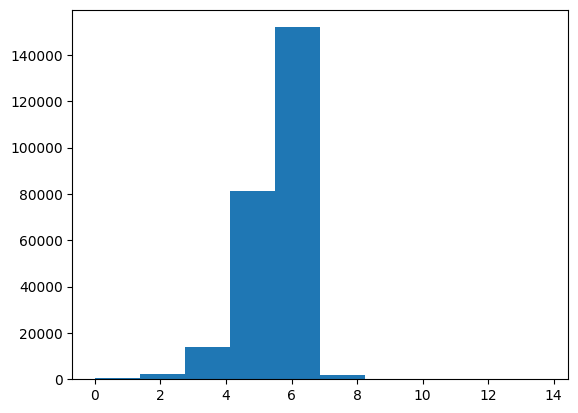

In [19]:
plt.hist(np.log(df["pages"]))

In [20]:
# create pipeline to do imputation using median
# one hot encoding of categorial variables
# and power transformation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])
min_max_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", MinMaxScaler()),
])
one_cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("one_hot", OneHotEncoder(drop='first')),
])
pow_num_pipeline = Pipeline([
    ("impute", IterativeImputer(initial_strategy="median")),
    ("log", PowerTransformer()),
    ("standardize", StandardScaler()),
])

In [21]:
num_attrs = ['rating']
min_max_attrs = ['genre_freq', 'author_freq', 'year']
one_cat_attrs = ['award', 'page_missing']
pow_num_attrs = ['num_of_rating', 'num_of_review', 'pages']

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attrs),
    ("min_max", min_max_pipeline, min_max_attrs),
    ("one_cat", one_cat_pipeline, one_cat_attrs),
    ("pow_num", pow_num_pipeline, pow_num_attrs)
], sparse_threshold=0)

In [22]:
# run pipeline on training and testing data
df_prepared = preprocessing.fit_transform(df)

In [23]:
df_prep = pd.DataFrame(
    df_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=df.index)

In [24]:
df_prep.head()

,num__rating,min_max__genre_freq,min_max__author_freq,min_max__year,one_cat__award_[1],pow_num__num_of_rating,pow_num__num_of_review,pow_num__pages
0,0.402832,0.004808,0.000000,0.083927,0.0,-0.343204,-1.381449,2.136920
1,0.492786,0.433705,0.025316,0.086142,0.0,0.382088,-1.515747,-0.068730
2,1.902066,0.000000,0.001582,0.087663,0.0,-0.659144,-1.515747,0.722850
3,0.822618,0.009246,0.000000,0.087402,0.0,-1.418880,0.514127,0.233058
4,-2.805527,0.000647,0.001582,0.085534,0.0,-0.343204,-1.515747,-0.501295


In [25]:
df_prep.columns = ['rating', 'genre_freq', 'author_freq', 'year', 'award', 'num_ratings', 'num_reviews', 'num_pages']

In [26]:
df_prep.corr()

,rating,genre_freq,author_freq,year,award,num_ratings,num_reviews,num_pages
rating,1.000000,-0.049373,0.068806,0.035815,-0.016934,0.016381,0.028755,0.124433
genre_freq,-0.049373,1.000000,0.165663,-0.023362,0.116990,-0.054038,0.054910,0.153248
author_freq,0.068806,0.165663,1.000000,-0.044913,0.105684,-0.029212,-0.036892,0.047675
year,0.035815,-0.023362,-0.044913,1.000000,-0.008367,0.007419,0.025437,0.009045
award,-0.016934,0.116990,0.105684,-0.008367,1.000000,-0.023652,-0.103627,0.138032
num_ratings,0.016381,-0.054038,-0.029212,0.007419,-0.023652,1.000000,-0.327824,-0.074678
num_reviews,0.028755,0.054910,-0.036892,0.025437,-0.103627,-0.327824,1.000000,0.044370
num_pages,0.124433,0.153248,0.047675,0.009045,0.138032,-0.074678,0.044370,1.000000


### 3) Model Testing

#### KMeans

In [25]:
from sklearn.cluster import KMeans
inertia = []
for i in range(5,20):
    km = KMeans(n_clusters = i, n_init=10, random_state=42)
    model = km.fit(df_prep)
    print(model.inertia_)
    inertia.append(model.inertia_)
    labels = model.labels_

529829.537489512
482405.7512293506
453084.3197431753
420922.3113538034
393988.8797020721
376233.54537213605
361172.87300693354
348421.91443383624
337174.243830431
327146.5407047045
317453.7035275561
308958.70517758065
300108.57540714764
292113.3843938249
284861.33539071865


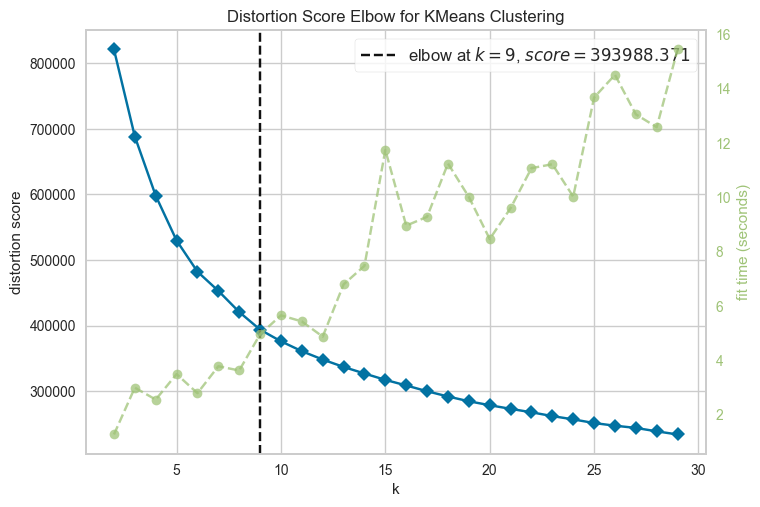

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans(n_init=10, random_state=42)
vis = KElbowVisualizer(km, k=(2,30))

vis.fit(df_prep)
vis.show()

c:\Users\tnaga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


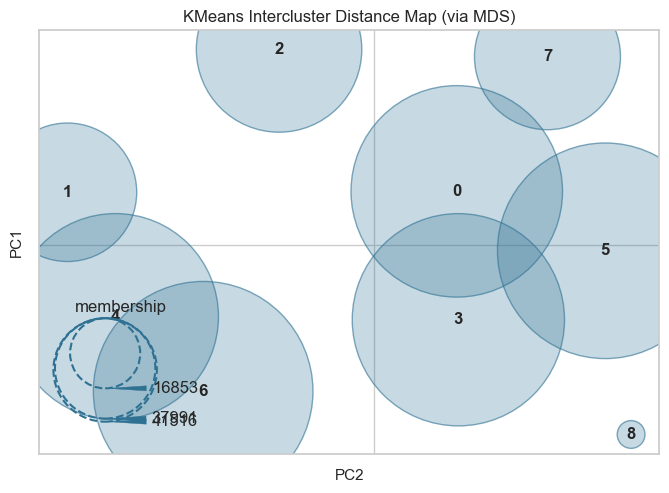

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [28]:
from yellowbrick.cluster.icdm import InterclusterDistance
km = KMeans(n_clusters=9, n_init=10, random_state=42)
vis_clust = InterclusterDistance(km)
vis_clust.fit(df_prep)
vis_clust.show()

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=df_prep.shape[1]-1)
X_PCA = pca.fit_transform(df_prep)
df_PCA = pd.DataFrame(X_PCA, columns = [f"PC{i}" for i in range(1,len(df_prep.columns))])

df_components = pd.DataFrame(pca.components_, columns=df_prep.columns)
df_components = df_components.T
df_components.columns = [f"PC{i}" for i in range(1,len(df_prep.columns))]


In [30]:
pca.explained_variance_ratio_

array([0.31815767, 0.26029095, 0.2072224 , 0.15664154, 0.03191131,
       0.02390075, 0.00187171])

In [31]:
df_PCA.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.075815,1.821166,1.518778,-0.970790,0.493008,0.222416,-0.037057
1,-1.234385,0.655514,-0.072541,-0.832569,0.144277,-0.254642,-0.031381
2,-0.160670,1.954455,-0.437481,-1.671143,0.363213,0.146325,-0.048304
3,1.459452,0.347722,-0.460161,-0.731496,0.270441,0.210821,-0.035194
4,-1.262482,-2.146293,1.841493,-0.941812,0.363711,0.198405,-0.012310


In [32]:
df_components

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
rating,0.117846,0.718706,-0.670088,-0.139989,-0.022709,-0.019697,-0.007458
genre_freq,0.029125,0.014344,0.057771,0.013839,-0.364868,-0.927369,-0.047685
author_freq,0.001184,0.006871,0.000259,-0.007017,-0.036869,-0.036786,0.998592
year,0.000054,0.000101,-0.000108,0.000112,0.000127,0.000259,-0.001886
award,-0.005169,0.034397,0.066547,-0.047013,-0.925018,0.368844,-0.021144
num_ratings,-0.676931,0.204819,-0.045748,0.704942,-0.027678,0.000296,0.003348
num_reviews,0.672991,-0.178592,-0.215164,0.682282,-0.047302,0.033517,0.004770
num_pages,0.272182,0.638890,0.703440,0.124500,0.079587,0.032790,0.000120


In [33]:
fitted = km.fit(df_prep)
labels = fitted.labels_
centers = fitted.cluster_centers_

In [34]:
pca_centers = pca.transform(centers)

df_centers = pd.DataFrame(pca_centers, columns=[f"PC{i}" for i in range(1,len(df_prep.columns))])

c:\Users\tnaga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [35]:
df_centers

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.804510,-0.068302,0.348251,0.926090,0.016360,-0.009367,-0.010954
1,0.958322,-1.279032,-1.065518,-0.391300,-0.070695,-0.008944,0.027226
2,-1.354830,-1.052426,-1.254926,-0.138735,-0.031018,-0.004085,0.001373
3,-0.631279,0.967261,-0.705450,0.392546,0.084405,0.011660,-0.014632
4,1.493652,-0.750546,0.519071,0.158202,-0.036762,-0.005813,-0.002939
5,-0.786597,0.468119,0.509810,-0.971142,-0.076615,-0.003457,0.003990
6,1.544991,0.352800,-0.334828,-0.161919,0.026128,-0.010276,0.004776
7,-1.104554,-1.424974,1.240551,-0.164827,0.134551,0.035860,-0.004241
8,-0.179964,2.060568,1.092388,0.127641,-0.113382,0.036443,0.038837


(-9.740520725129452, 10.2)

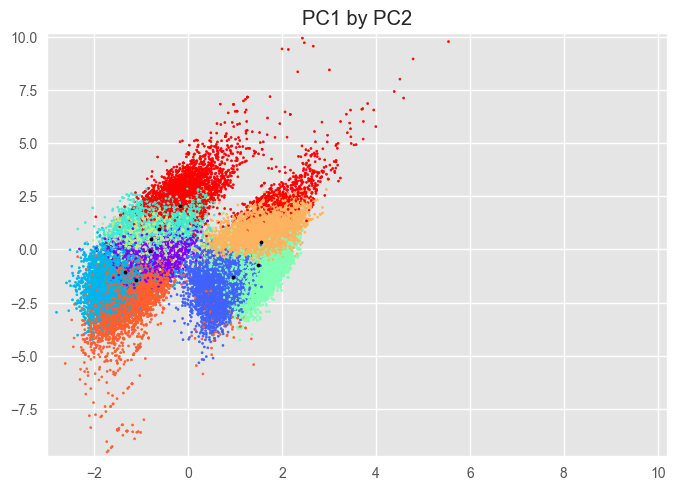

In [41]:
pc1 = 1
pc2 = 2

pcs = [f"PC{i}" for i in range(1,len(df_prep.columns))]
plt.style.use('ggplot')
plt.scatter(df_PCA[pcs[pc1-1]], df_PCA[pcs[pc2-1]], c=labels, cmap='rainbow', s=2)
plt.scatter(df_centers[pcs[pc1-1]], df_centers[pcs[pc2-1]], c='black', s=5)
plt.title(f"{pcs[pc1-1]} by {pcs[pc2-1]}")
plt.xlim((max(min(df_PCA[pcs[pc1-1]]), -10) - 0.2, min(max(df_PCA[pcs[pc1-1]]), 10) + 0.2))
plt.ylim((max(min(df_PCA[pcs[pc2-1]]), -10) - 0.2, min(max(df_PCA[pcs[pc2-1]]), 10) + 0.2))

In [37]:
pc1 = 1
pc2 = 2
pc3 = 3

df = pd.concat([df_PCA, pd.Series(labels, name="Labels")], axis=1)
df.head()
import plotly.express as px
fig = px.scatter_3d(df, x=f"PC{pc1}", y=f"PC{pc2}", z=f"PC{pc3}",
              color='Labels')
fig.show(renderer="browser")